This notebook will be used to upload, search and plot using the HUGS Cloud platform

In [ ]:
import os
import sys
from datetime import datetime
sys.path.insert(0, "../../..")
sys.path.insert(0, "../../../../acquire")

from HUGS.Processing import search
from HUGS.Client import Process, Search, Retrieve

from Acquire.ObjectStore import datetime_to_string
from Acquire.Client import User, Drive, Service, PAR, Authorisation, StorageCreds

from bqplot import pyplot as plt
from bqplot import DateScale, LinearScale, LogScale, Axis, Lines, Figure, Scatter
from random import randint    

from numpy import random as np_random
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_json as pd_read_json

from ipywidgets import HBox, VBox

In [ ]:
%matplotlib notebook

In [ ]:
# Autoreload modules before executing code, useful during development
%load_ext autoreload
%autoreload 2

## Login

Login to the platform

In [ ]:
base_url = "https://hugs.acquire-aaai.com/t"
user = User(username="gareth", identity_url=F"{base_url}/identity")
response = user.request_login()

Login by visiting: https://login.acquire-aaai.com?id=a0-a6/30.25.5b.f7
(please check that this page displays the message 'small sheep run quietly')


Check we've logged in successfully

In [ ]:
user.wait_for_login()

True

## Upload

First we want to upload the data to the cloud platform

In [ ]:
# Helper function for test file paths
def get_path(filename, data_type="CRDS"):
    dir_path = os.path.abspath("")
    test_data = f"../../../test/data/proc_test_data/{data_type}"
    return os.path.join(dir_path, test_data, filename)

Get a process object so we can send files to the platform

In [ ]:
processing = Process(service_url=base_url)

For the time being clear Datasources

In [ ]:
hugs = Service(service_url="%s/hugs" % base_url)
# hugs.call_function(function="clear_datasources", args={})

Upload some data

In [ ]:
bsd_file = get_path("bsd.picarro.1minute.248m.dat", data_type="CRDS")
hfd_file = get_path("hfd.picarro.1minute.100m_min.dat", data_type="CRDS")
""
result_bsd = processing.process_files(user=user, files=bsd_file, data_type="CRDS", source_name="bsd.picarro.1minute.248m")
result_hfd = processing.process_files(user=user, files=hfd_file, data_type="CRDS", source_name="hfd.picarro.1minute.100m_min")

In [ ]:
print(result_bsd, "\n\n", result_hfd)

Get a search object

In [ ]:
search = Search(service_url=base_url)

In [ ]:
start = datetime(1970, 1,1)
end = datetime.now()

search_terms = ["co"]
search_locations = []
data_type = "CRDS"

search_results = search.search(search_terms=search_terms, locations=search_locations, 
                               data_type=data_type, start_datetime=start, end_datetime=end)


['co'] []


In [ ]:
search_results

{'bsd_co': ['data/uuid/0ad33eb6-00a6-4a41-9c7e-3d0c53bd7653/2014-01-30T10:52:30_2014-01-30T14:20:30'],
 'hfd_co': ['data/uuid/6c43c43a-2621-464f-850d-bd073eb6d483/2013-12-04T14:02:30_2013-12-25T22:56:30',
  'data/uuid/6c43c43a-2621-464f-850d-bd073eb6d483/2014-01-01T18:25:30_2014-12-28T08:02:30',
  'data/uuid/6c43c43a-2621-464f-850d-bd073eb6d483/2015-01-04T17:22:30_2015-12-30T14:55:30',
  'data/uuid/6c43c43a-2621-464f-850d-bd073eb6d483/2016-01-06T18:01:30_2016-12-29T02:17:30',
  'data/uuid/6c43c43a-2621-464f-850d-bd073eb6d483/2017-01-01T19:56:30_2017-12-26T07:35:30',
  'data/uuid/6c43c43a-2621-464f-850d-bd073eb6d483/2018-01-02T13:10:30_2018-12-30T10:12:30',
  'data/uuid/6c43c43a-2621-464f-850d-bd073eb6d483/2019-01-06T11:02:30_2019-05-21T15:46:30']}

Get the keys we want 

In [ ]:
print(list(search_results.keys()))

['bsd_co', 'hfd_co']


The items stored at each key are the keys for the data

In [ ]:
search_results["bsd_co"]

['data/uuid/0ad33eb6-00a6-4a41-9c7e-3d0c53bd7653/2014-01-30T10:52:30_2014-01-30T14:20:30']

Now create a list of the terms we want to download

In [ ]:
to_download = ["bsd_co", "hfd_co"]

Now we can (for now) pull this data from the object store for use

In [ ]:
retrieve = Retrieve(service_url=base_url)

In [ ]:
download_keys = {key: search_results[key] for key in to_download}

In [ ]:
data = retrieve.retrieve(keys=download_keys)

Create a list of DataFrames

In [ ]:
# Should make this a HUGS function within Client ?
def json_to_dataframe(data_dict):
    dataframes = {}
    for key in data_dict:
        dataframes[key] = pd_read_json(data_dict[key])
        
    return dataframes

def download_keys(key_dict, download_keys=None):
    """
        Downloads the keys and converts the passed JSON data into Pandas DataFrames
        
        Args:
            key_dict (dict): Dictionary keyed by site_searchterm containing the
                             keys to access the data
            download_keys (list, default=None): List of keys to download
        Returns:
            dict: Dictionary of DataFrames
    """
    if download_keys:
        download_keys = {key: search_results[key] for key in to_download}
    else:
        download_keys = key_dict
    
    return json_to_dataframe(retrieve.retrieve(keys=download_keys))    
    

Convert the data from JSON to DataFrames

In [ ]:
dataframes = json_to_dataframe(data)

## Plots

Plot some time series using bqplot. Here we use their internal object model. It's also possible to use a more `matplotlib` like interface. See https://bqplot.readthedocs.io/en/latest/usage.html

In [ ]:
x_scale = DateScale()
y_scale = LinearScale()
scales = {"x": x_scale, "y": y_scale}

ax = Axis(label="Date", scale=x_scale)
ay = Axis(label="Count", scale=y_scale, orientation="vertical")

bsd_data = dataframes["bsd_co"]

x_data = bsd_data.index
y_data = bsd_data.iloc[:,0]

scatter = Scatter(x=x_data, y=y_data, scales=scales)
figure = Figure(marks=[scatter], axes=[ax, ay], animation_duration=1000)
figure

Figure(animation_duration=1000, axes=[Axis(label='Date', scale=DateScale()), Axis(label='Count', orientation='…

We can also just plot using `pandas` plotting inline

In [ ]:
hfd_data = dataframes["hfd_co"]

In [ ]:
hfd_data["co count"].plot()

### Plot multiple compounds for a single site - with the option to overlay 

Get the data from multiple sites as we have with our search call above

Plot the data from Bilsdale

In [ ]:
bsd_terms = ["bsd_co", "bsd_co2"]
bsd_keys = {key: search_results[key] for key in bsd_terms}
bsd_data = json_to_dataframe(retrieve.retrieve(keys=bsd_keys))

Now we can plot and compare the CO and CO2 data at Bilsdale

In [ ]:
x_scale = DateScale()
y_scale = LinearScale()
scales = {"x": x_scale, "y": y_scale}

ax = Axis(label="Date", scale=x_scale)
ay = Axis(label="Count", scale=y_scale, orientation="vertical")

co_data = bsd_data["bsd_co"]
co2_data = bsd_data["bsd_co2"]

co_x_data = co_data.index
co_y_data = co_data.iloc[:,0]

co2_x_data = co2_data.index
co2_y_data = co2_data.iloc[:,0]

co_scatter = Scatter(x=co_x_data, y=co_y_data, scales=scales, colors=["LightGreen"])
co2_scatter = Scatter(x=co2_x_data, y=co2_y_data, scales=scales, colors=["steelblue"])

figure = Figure(marks=[co_scatter, co2_scatter], axes=[ax, ay], animation_duration=1000)
figure



### Plot multiple compounds form different sites - with the option to overlay 

In [ ]:
search_results.keys()

In [ ]:
bsd_hfd_data = json_to_dataframe(retrieve.retrieve(keys=search_results))

In [ ]:
bsd_hfd_data.keys()

Upload some data from Tacolneston, `tac.picarro.1minute.100m.min.dat`

In [ ]:
tac_file = get_path("tac.picarro.1minute.100m.min.dat")
result_tac = processing.process_files(user=user, files=tac_file, data_type="CRDS")

In [ ]:
result_tac

Do a new search for the TAC and HFD data

In [ ]:
start = datetime(1970, 1,1)
end = datetime.now()

search_terms = ["ch4", "co2"]
search_locations = ["tac", "hfd"]
data_type = "CRDS"

search_results = search.search(search_terms=search_terms, locations=search_locations, 
                               data_type=data_type, start_datetime=start, end_datetime=end)

In [ ]:
hfd_tac_data = download_keys(key_dict=search_results)

In [ ]:
hfd_tac_data.keys()

In [ ]:
ch4_scales = {"x": DateScale(), "y": LinearScale()}
co2_scales = {"x": DateScale(), "y": LinearScale()}

ax = Axis(label="Date", scale=x_scale)
ay = Axis(label="Count", scale=y_scale, orientation="vertical")

tac_ch4_data = hfd_tac_data["tac_ch4"]
hfd_ch4_data = hfd_tac_data["hfd_ch4"]

tac_co2_data = hfd_tac_data["tac_co2"]
hfd_co2_data = hfd_tac_data["hfd_co2"]

tac_ch4_x = tac_ch4_data.index
tac_ch4_y = tac_ch4_data["ch4 count"]

hfd_ch4_x = hfd_ch4_data.index
hfd_ch4_y = hfd_ch4_data["ch4 count"]

tac_co2_x = tac_co2_data.index
tac_co2_y = tac_co2_data["co2 count"]

hfd_co2_x = hfd_co2_data.index
hfd_co2_y = hfd_co2_data["co2 count"]

# co_x_data = co_data.index
# co_y_data = co_data.iloc[:,0]

# co2_x_data = co2_data.index
# co2_y_data = co2_data.iloc[:,0]

tac_ch4_scatter = Lines(x=tac_ch4_x, y=tac_ch4_y, scales=ch4_scales, colors=["LightGreen"])
hfd_ch4_scatter = Lines(x=hfd_ch4_x, y=hfd_ch4_y, scales=ch4_scales, colors=["steelblue"])

tac_co2_scatter = Lines(x=tac_co2_x, y=tac_co2_y, scales=co2_scales, colors=["LightGreen"])
hfd_co2_scatter = Lines(x=hfd_co2_x, y=hfd_co2_y, scales=co2_scales, colors=["steelblue"])

ch4_figure = Figure(marks=[tac_ch4_scatter, hfd_ch4_scatter], axes=[ax, ay], animation_duration=1000, title="CH4")
co2_figure = Figure(marks=[tac_co2_scatter, hfd_co2_scatter], axes=[ax, ay], animation_duration=1000, title="CO2")


VBox(children=[ch4_figure, co2_figure])

# Upload some GC data and plot it
### Here we'll upload from data from Capegrim

In [ ]:
cape_data = get_path("capegrim-medusa.18.C", data_type="GC")
cape_prec = get_path("capegrim-medusa.18.precisions.C", data_type="GC")

cape_tup = cape_data, cape_prec

trinidad_data = get_path("trinidadhead.01.C", data_type="GC")
trinidad_prec = get_path("trinidadhead.01.precisions.C", data_type="GC")

trinidad_tup = trinidad_data, trinidad_prec
                          

In [ ]:
result_cape = processing.process_files(user=user, files=cape_tup, data_type="GC", source_name="capegrim-medusa.18")

In [ ]:
# result_trinidad = processing.process_files(user=user, files=trinidad_tup, data_type="GC", source_name="trinidadhead.01")

In [ ]:
result_cape

For the Capegrim file we should have 56 Datasources

In [ ]:
print(len(result_cape["capegrim-medusa.18.C"]))

In [ ]:
start = datetime(1970, 1,1)
end = datetime.now()

search_terms = ["H-2402", "CH3Cl", "CH2Cl2", "HFC-152a"]
search_locations = []
data_type = "GC"

search_results = search.search(search_terms=search_terms, locations=search_locations, 
                               data_type=data_type, start_datetime=start, end_datetime=end)

['H-2402', 'CH3Cl', 'CH2Cl2', 'HFC-152a'] []


In [ ]:
search_results

{'capegrim_H-2402': ['data/uuid/e0244e53-5963-4b2e-962b-91f06cc13eb7/2018-01-01T02:24:00_2018-01-31T23:33:00'],
 'capegrim_CH3Cl': ['data/uuid/2bcaaf3e-dc25-4c1e-9163-4195d2db1580/2018-01-01T02:24:00_2018-01-31T23:33:00'],
 'capegrim_CH2Cl2': ['data/uuid/44d4d5cf-9bb4-463e-b43c-d980638f8752/2018-01-01T02:24:00_2018-01-31T23:33:00'],
 'capegrim_HFC-152a': ['data/uuid/375a193f-7fe9-4473-9d4b-3edf28fbceba/2018-01-01T02:24:00_2018-01-31T23:33:00']}

In [ ]:
capegrim_data = download_keys(key_dict=search_results)

In [ ]:
capegrim_data

{'capegrim_H-2402':                      H-2402  H-2402 repeatability  H-2402 status_flag  \
 2018-01-01 02:24:00   0.402               0.00416                   0   
 2018-01-01 04:34:00   0.401               0.00416                   0   
 2018-01-01 06:44:00   0.403               0.00416                   0   
 2018-01-01 08:54:00   0.398               0.00416                   0   
 2018-01-01 11:04:00   0.395               0.00416                   0   
 ...                     ...                   ...                 ...   
 2018-01-31 14:53:00   0.400               0.00343                   0   
 2018-01-31 17:03:00   0.397               0.00343                   0   
 2018-01-31 19:13:00   0.392               0.00343                   0   
 2018-01-31 21:23:00   0.393               0.00343                   0   
 2018-01-31 23:33:00   0.393               0.00343                   0   
 
                      H-2402 integration_flag  Inlet  
 2018-01-01 02:24:00                

In [ ]:
H2402_data = capegrim_data["capegrim_H-2402"]["H-2402"]

In [ ]:
H2402_data = capegrim_data["capegrim_H-2402"]["H-2402"]
CH3Cl_data = capegrim_data["capegrim_CH3Cl"]["CH3Cl"]
CH2Cl2_data = capegrim_data["capegrim_CH2Cl2"]["CH2Cl2"]
HFC152a_data = capegrim_data["capegrim_HFC-152a"]["HFC-152a"]

<IPython.core.display.Javascript object>


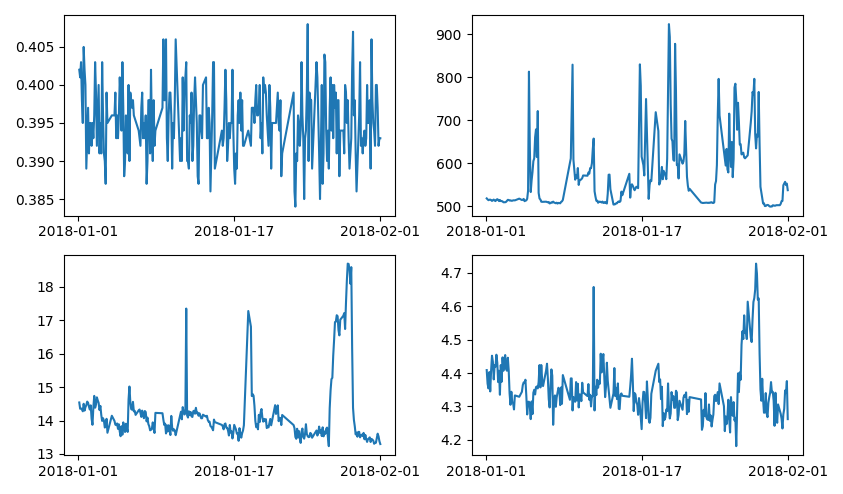

In [ ]:
fig = plt.figure(tight_layout=True)

ax = fig.add_subplot(221)
ax.plot(H2402_data.index, H2402_data.values)
ax.set_xticks(ax.get_xticks()[::4])
ax = fig.add_subplot(222)
ax.plot(CH3Cl_data.index, CH3Cl_data.values)
ax.set_xticks(ax.get_xticks()[::4])
ax = fig.add_subplot(223)
ax.plot(CH2Cl2_data.index, CH2Cl2_data.values)
ax.set_xticks(ax.get_xticks()[::4])
ax = fig.add_subplot(224)
ax.plot(HFC152a_data.index, HFC152a_data.values)
ax.set_xticks(ax.get_xticks()[::4])




### Creating multiple plots

In [ ]:
x_scale = DateScale()
y_scale = LinearScale()
date_line_scales = {"x": x_scale, "y": y_scale}

x_scale2 = DateScale()
y_scale2 = LinearScale()
date_line_scales2 = {"x": x_scale2, "y": y_scale2}

ax = Axis(label="Date", scale=x_scale, visible=True, tick_style={"font-size":12})
ay = Axis(label="Count", scale=y_scale, orientation="vertical", visible=True, tick_style={"font-size":12})

H2402_lines= Lines(x=H2402_data.index, y=H2402_data, scales=date_line_scales)
H2402_fig = Figure(marks=[H2402_lines], axes=[ax,ay], title="H2402")



CH3Cl_lines= Lines(x=CH3Cl_data.index, y=CH3Cl_data, scales=date_line_scales2)
CH3Cl_fig = Figure(marks=[CH3Cl_lines], axes=[ax,ay], title="CH3Cl")

# CH2Cl2_lines= Lines(x=CH2Cl2_data.index, y=CH2Cl2_data, scales={"x": DateScale(), "y": LinearScale()})
# CH2Cl2_fig = Figure(marks=[CH2Cl2_lines], axes=[ax,ay], title="CH2Cl2")

# HFC152a_lines = Lines(x=HFC152a_data.index, y=HFC152a_data, scales={"x": DateScale(), "y": LinearScale()})
# HFC152a_fig = Figure(marks=[HFC152a_lines], axes=[ax,ay], title="HFC152a")

# top_line = HBox(children=[H2402_fig, CH3Cl_fig])
# bot_line = HBox(children=[CH2Cl2_fig, HFC152a_fig])

# grid = VBox(children=[top_line, bot_line])
# grid

In [ ]:
H2402_fig

Figure(axes=[Axis(label='Date', scale=DateScale(), side='bottom', tick_style={'font-size': 12}), Axis(label='C…

In [ ]:
CH3Cl_fig

Figure(axes=[Axis(label='Date', scale=DateScale(), side='bottom', tick_style={'font-size': 12}), Axis(label='C…